## Clasificación de defectos 

### Se importan las librerías

In [3]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
from skimage import morphology
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.transform import rotate
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import kurtosis
from scipy.stats import skew
import os
import skimage.morphology as morph
import random
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Funciones de Segmentación y Extracción de características

In [0]:
def segment(img): #Función de segmentación
    img_rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Se obtiene cada canal del espacio CMY con una transformación lineal
    #a los canales R, G y B
    img_C = 255 - img_rgb[:,:,0]
    img_M = 255 - img_rgb[:,:,1]
    img_Y = 255 - img_rgb[:,:,2]
    img = img_Y
    h,w = np.shape(img)
    center = (w / 2, h / 2) 
    if (h == 2256): #Rotar la imagen
        img = rotate(img, angle=90,resize=True, order=0)
        img_rgb = rotate(img_rgb, angle=90, resize=True, order=0)
    #bw = closing(img > thresh, square(3))
    #Definir tamaño del kernel
    k_size = 9
    #aplicar filtro de suavizado
    img = cv2.blur(img, (k_size,k_size))
    thresh = threshold_otsu(img) #Threshold automático con el método otsu
    img = img > thresh
    img = morph.remove_small_holes(img,min_size=100) #rellenar espacios pequeños
    label_img = label(img)
    segmented = None
    props = regionprops(label_img)
    for prop in props: #Se evaluan las propiedades para obtener el grano de café
        a = prop.area
        p = prop.perimeter
        redondez = 4*np.pi*a/p**2
        
        label_n = prop.label
        #print("Area: {} Perimetro: {} Redondez: {}".format(a,p,redondez))
        if ((a > 40000 and not(redondez > 0.72 and redondez < 0.78)) or( p < 1000 and a > 45000 and a < 60000 ) ): #Se ha notado que los cuadrados tienen redondez entre esos rangos
            segmented = label_img == label_n
            print(label_n)
            break    
    
    img_rgb[:,:,0] = (img_rgb[:,:,0]*segmented)
    img_rgb[:,:,1] = (img_rgb[:,:,1]*segmented)
    img_rgb[:,:,2] = (img_rgb[:,:,2]*segmented)
    
    #plt.show() 
    
    return [segmented, img_rgb]

def get_moments_hu(props, features):
    moments_hu = props.moments_hu
    moments_hu = np.sign(moments_hu) * np.log(np.abs(moments_hu))
    features['hu0'] = moments_hu[0]
    features['hu1'] = moments_hu[1]
    features['hu2'] = moments_hu[2]
    features['hu3'] = moments_hu[3]
    features['hu4'] = moments_hu[4]
    features['hu5'] = moments_hu[5]
    features['hu6'] = moments_hu[6]
    return features

def get_features_topological(props, features):
    features['euler_num'] = props.euler_number
    return features

def get_features_area(props, features):
    
    features['orientation'] = props.orientation
    features['area_to_convex_ratio'] = props.area/props.convex_area
    features['compacity'] = props.perimeter**2/props.area
    features['roundness'] = 4*np.pi*props.area /(props.perimeter**2)
    #print(i)
    features['area_perimeter_ratio'] = props.area / props.perimeter
    features['elongation'] = props.major_axis_length/props.minor_axis_length
    features['solidity1'] = props.area/props.convex_area
    features['solidity2'] = props.area / props.filled_area
    return features

def get_features(img):
    features = {}
    img *= morphology.remove_small_objects(img.astype(bool), min_size = 20)
    label_img = label(img)
    props = regionprops(label_img)[0]
    features = get_moments_hu(props, features)
    features = get_features_topological(props, features)
    features = get_features_area(props, features)
    return features





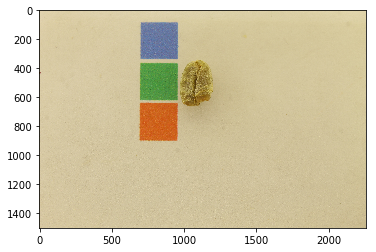

1


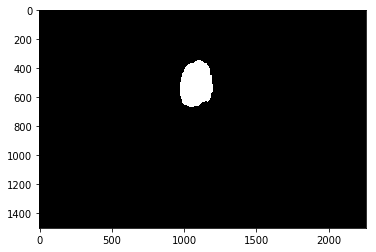

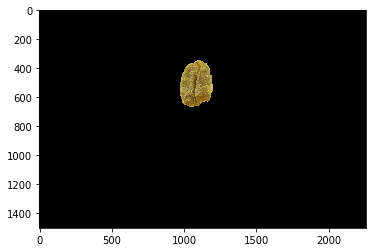

In [0]:
def segmentar_y_plotear(numero):
  
  #Esta ruta se pone porque se estuvo trabajando en Google Colab
  filename = "/content/drive/My Drive/9no Semestre/Visión artificial/CAFE/Mordido/IMG_"+str(numero)+".JPG"
  #filename = "pon aqui otra ruta en caso de que no estes trabajando en Colab"
  
  img = cv2.imread(filename, cv2.IMREAD_COLOR)
  img_rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  imgplt1 = plt.imshow(img_rgb)
  plt.show()
  results = segment(img) ##Segmentar la imagen
  mask = results[0] #Imagen binaria segmentada 
  img = results[1] #Imagen original segmentada
  #img = img.astype(np.float32)


  imgplt = plt.imshow(mask,cmap='gray')
  plt.show()

  imgplot = plt.imshow(img) 
  plt.show()
  features = get_features(mask) #Diccionario de características

segmentar_y_plotear(5633)

La función anterior produce un diccionario "features" con las características extraidas de la imagen

In [0]:
print(features)

{'hu0': -1.8014972058891026, 'hu1': -7.607002895772615, 'hu2': -8.074874238854965, 'hu3': -13.867497201543394, 'hu4': -26.44946629736854, 'hu5': -17.83349770629461, 'hu6': -24.859037936530882, 'euler_num': 1, 'orientation': -1.2459669011109118, 'area_to_convex_ratio': 0.9720979699083487, 'compacity': 18.853433921913176, 'roundness': 0.6665295386721776, 'area_perimeter_ratio': 70.32098407951456, 'elongation': 1.1455612780850897, 'solidity1': 0.9720979699083487, 'solidity2': 1.0}


### Clasificación

<p>Las clases para la clasificación son de café verde</p>
<ul>
    <li>Arrugado</li>
    <li>Broca</li>
    <li>Mordido</li>
    <li>Bueno</li>
    <li>Malo</li>
</ul>
<p>
    Para la clasificación se requiere armar un data set con las características de cada imagen y clasificadas previamente según su clase, y aplicar para las características topológicas y de forma una selección de características por enfoques estadísticos, y luego para las características de textura la utilización de wrappers
</p>

In [0]:
def filter(form, texture):
    #Explorar que características 
    
def pre_filter():
    path = "CAFE/Clasificar/"
    files = os.listdir(path)
    clasification_dict = {
        "Broca":[],
        "Bien":[],
        "Arrugados":[],
        "Mordido":[],
        "Malos":[]
    }
    for file in files:
        img = cv2.imread(path+file, cv2.IMREAD_COLOR)
        results = segment(img) ##Segmentar la imagen
        mask = results[0] #Imagen binaria segmentada 
        img = results[1] #Imagen original segmentada
        img = img.astype(np.float32)
        form_f = form_features(mask) #Diccionario de características de forma(ingresando solo la máscara)
        texture_f = features_pipeline(img,mask) #Diccionario de características de textura
        place = filter(form_f,texture_f)
        clasification_dict[place].append(file)
    return clasification_dict

#Armar el Data Set

Necesario en Colab para importar imágenes

In [0]:
from google.colab import files
uploaded = files.upload()

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Lectura de imágenes, extracción de características de las mismas y guardado en listas

In [0]:
#Esta funcion construye rutas para leer las imagenes, lee las imagenes con las rutas,
#llama funciones previamente definidas de segmentacion y extraccion de caracteristicas,
#agrega las caracteristicas "archivo" y "categoria", guarda las caracteristicas en un diccionario 
#y finalmente devuelve todas las tuplas de caracteristicas en una lista de diccionarios

def leerDatosColab(inicio,fin,categoria):
  
  path = "/content/drive/My Drive/9no Semestre/Visión artificial/CAFE/"
  #path = "CAFE/Clasificar/" #Esta otra ruta se usaría si no estuvieramos trabajando en Colab
  #Si ejecutas este codigo y no estas en Colab, usa la otra ruta
  
  if categoria == "Arrugados":
    path += "Arrugados/"
  if categoria == "Broca":
    path += "Broca/"
  if categoria == "Mordido":
    path += "Mordido/"
  
  bigData = [] #Se llena con los diccionarios de datos de cada imagen procesada
  #Lista negra
  lista_negra_mordido = [5548,5576,5593,5607,5617,5632,5637,5641] #Estos granos se segmentan con todo y cuadro
  lista_negra_arrugados = [5778,5782,5783,5824,5826,5830]
  lista_negra_broca = [5659,5664,5668,5678,5681,5682,5686,5699,5704,5712,5738,5736,5735,5734]
  
  black_list = lista_negra_mordido + lista_negra_arrugados + lista_negra_broca

  for i in range(inicio, fin+1):
    
    if i not in black_list:
    
      archivo = "IMG_"+str(i)+".JPG" #Construccion del nombre del archivo
      current_img = path + archivo #Construccion de la ruta del archivo completa

      try: #Este try se implementa porque algunas imagenes tienen un problema con la segmentacion

        img = cv2.imread(current_img, cv2.IMREAD_COLOR) 
        results = segment(img) ##Segmentar la imagen
        mask = results[0] #Imagen binaria segmentada 
        segmented = results[1] #Imagen original segmentada
        features = get_features(mask)#Obtener caracteristicas geometricas de la imagen actual
        features.update({'categoria' : categoria })#add esta caracteristica para posterior uso en red neuronal
        features.update({'archivo' : archivo }) #Add esta otra caracteristica por si es util en algun momento de la vida
        bigData.append(features) #Poner una nueva fila que corresponde a las caracteristicas de una nueva imagen en la lista

      except:
        print(archivo)
        pass
    
  return bigData


### Lectura de los tres tipos de cafe que clasificaremos

#### lectura de los granos arrugados

In [13]:
data_arrugado = leerDatosColab(5766,5830,"Arrugados") #ARRUGADO -Este es el rango de las imágenes de café arrugado
data_arrugado

1
2
1
1
1
1
1
1
1
1
1
1
IMG_5779.JPG
1
1
1
1
IMG_5786.JPG
IMG_5787.JPG
2
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
IMG_5804.JPG
IMG_5805.JPG
1
1
1
1
1
1
2
1
2
1
IMG_5816.JPG
IMG_5817.JPG
2
1
1
IMG_5821.JPG
1
2
1
1
1
1


[{'archivo': 'IMG_5766.JPG',
  'area_perimeter_ratio': 70.32666001563007,
  'area_to_convex_ratio': 0.8978979370816426,
  'categoria': 'Arrugados',
  'compacity': 27.82702731895104,
  'elongation': 1.8598062744288941,
  'euler_num': 1,
  'hu0': -1.5674383067222049,
  'hu1': -4.3252601436274665,
  'hu2': -9.140656019779595,
  'hu3': -11.52748176683692,
  'hu4': -21.94730138197591,
  'hu5': -13.797490333568978,
  'hu6': 22.78539520293877,
  'orientation': -0.010512072462422169,
  'roundness': 0.4515886828414869,
  'solidity1': 0.8978979370816426,
  'solidity2': 1.0},
 {'archivo': 'IMG_5767.JPG',
  'area_perimeter_ratio': 52.57403873413231,
  'area_to_convex_ratio': 0.9653776591163552,
  'categoria': 'Arrugados',
  'compacity': 24.331867229407585,
  'elongation': 1.2994660376497278,
  'euler_num': 1,
  'hu0': -1.7935841156470178,
  'hu1': -6.31137302178033,
  'hu2': -11.405835884167198,
  'hu3': -15.393142409943431,
  'hu4': 29.834265247823755,
  'hu5': -18.56945972967766,
  'hu6': 28.859

#### Lectura de los granos mordidos

In [14]:
data_mordido = leerDatosColab(5532,5655,"Mordido") #Mordido -Este es el rango de las imágenes de café mordidas
data_mordido

IMG_5532.JPG
IMG_5533.JPG
2
1
IMG_5536.JPG
IMG_5537.JPG
1
5
IMG_5540.JPG
1
IMG_5542.JPG
IMG_5543.JPG
1
1
1
2
IMG_5549.JPG
1
2
1
2
1
1
2
1
IMG_5558.JPG
IMG_5559.JPG
IMG_5560.JPG
2
1
2
1
1
1
1
1
1
IMG_5570.JPG
1
2
IMG_5573.JPG
IMG_5574.JPG
IMG_5575.JPG
IMG_5577.JPG
IMG_5578.JPG
1
1
IMG_5581.JPG
1
2
2
IMG_5585.JPG
IMG_5586.JPG
IMG_5587.JPG
IMG_5588.JPG
IMG_5589.JPG
1
2
1
IMG_5594.JPG
IMG_5595.JPG
IMG_5596.JPG
1
1
IMG_5599.JPG
1
1
2
1
IMG_5604.JPG
IMG_5605.JPG
IMG_5606.JPG
1
IMG_5609.JPG
IMG_5610.JPG
2
1
2
2
1
2
1
2
1
1
1
1
1
1
1
IMG_5627.JPG
1
1
1
IMG_5631.JPG
1
1
1
1
1
IMG_5639.JPG
IMG_5640.JPG
1
IMG_5643.JPG
IMG_5644.JPG
1
1
IMG_5647.JPG
IMG_5648.JPG
IMG_5649.JPG
1
2
IMG_5652.JPG
IMG_5653.JPG
2
1


[{'archivo': 'IMG_5534.JPG',
  'area_perimeter_ratio': 70.12826503629917,
  'area_to_convex_ratio': 0.9781373533486711,
  'categoria': 'Mordido',
  'compacity': 15.647298446826065,
  'elongation': 1.1180944501015224,
  'euler_num': 1,
  'hu0': -1.8181076369497744,
  'hu1': -8.029703299733375,
  'hu2': -9.49756509165211,
  'hu3': -15.932073658647392,
  'hu4': -28.782601624759522,
  'hu5': 20.817683318873897,
  'hu6': -29.36526264775109,
  'orientation': -1.2398593490717682,
  'roundness': 0.803101612528402,
  'solidity1': 0.9781373533486711,
  'solidity2': 1.0},
 {'archivo': 'IMG_5535.JPG',
  'area_perimeter_ratio': 72.19190130562299,
  'area_to_convex_ratio': 0.9875779546722101,
  'categoria': 'Mordido',
  'compacity': 14.949524973604545,
  'elongation': 1.149568313426971,
  'euler_num': 1,
  'hu0': -1.8196806983713707,
  'hu1': -7.593264762944136,
  'hu2': -9.460698110153086,
  'hu3': -15.731947618262566,
  'hu4': 30.575500826780985,
  'hu5': -20.187265046300244,
  'hu6': 28.333887264

#### Lectura de los granos con broca

In [15]:
data_broca = leerDatosColab(5659,5740,"Broca") #Broca -Este es el rango de las imágenes de café con Broca
data_broca

IMG_5660.JPG
1
1
1
2
1
2
1
IMG_5670.JPG
1
1
2
2
1
1
1
1
2
1
1
1
2
1
1
2
2
1
1
IMG_5694.JPG
1
2
1
1
IMG_5700.JPG
1
2
2
1
2
2
1
1
IMG_5710.JPG
1
2
1
2
2
1
3
1
1
2
2
1
1
1
1
1
1
2
1
1
1
2
2
IMG_5739.JPG
2


[{'archivo': 'IMG_5661.JPG',
  'area_perimeter_ratio': 79.65399144486551,
  'area_to_convex_ratio': 0.9919983586376693,
  'categoria': 'Broca',
  'compacity': 14.478880815868134,
  'elongation': 1.296285637610663,
  'euler_num': 1,
  'hu0': -1.8029366846606452,
  'hu1': -6.348049792713948,
  'hu2': -11.43289082224856,
  'hu3': -16.014259013206672,
  'hu4': -32.61968433521178,
  'hu5': 21.323274049098952,
  'hu6': -29.739406135918962,
  'orientation': 1.3152385208235797,
  'roundness': 0.8679103567581725,
  'solidity1': 0.9919983586376693,
  'solidity2': 1.0},
 {'archivo': 'IMG_5662.JPG',
  'area_perimeter_ratio': 68.56010292531907,
  'area_to_convex_ratio': 0.9835326953748006,
  'categoria': 'Broca',
  'compacity': 15.743259958596543,
  'elongation': 1.402901773828389,
  'euler_num': 1,
  'hu0': -1.7775360970516012,
  'hu1': -5.795709535523904,
  'hu2': -10.060583914750806,
  'hu3': -13.743480484519655,
  'hu4': -27.096128075012356,
  'hu5': -18.35898085970867,
  'hu6': -25.67377433671

### Crear un Pandas dataframe para usarlo en la red neuronal

In [16]:
bigData = data_mordido + data_broca #+ data_arrugado #Unimos las tres listas
random.shuffle( bigData ) #Barajamos la big data, por si eso le ayuda a la Red Neuronal
cafe_db_3cat = pd.DataFrame( bigData ) #Convertimos a un dataframe en pandas
cafe_db_3cat.head()

,archivo,area_perimeter_ratio,area_to_convex_ratio,categoria,compacity,elongation,euler_num,hu0,hu1,hu2,hu3,hu4,hu5,hu6,orientation,roundness,solidity1,solidity2
0,IMG_5702.JPG,50.674787,0.987962,Broca,15.691603,1.625217,1,-1.719293,-5.032268,-10.114856,-12.949097,-24.484967,-15.468602,-26.910735,1.345984,0.800834,0.987962,1.000000
1,IMG_5688.JPG,64.288639,0.992241,Broca,14.511633,1.312862,1,-1.800662,-6.252255,-12.231237,-16.250498,-32.000276,-21.409517,-30.516438,1.397587,0.865952,0.992241,1.000000
2,IMG_5538.JPG,73.175261,0.969327,Mordido,17.646448,1.193765,1,-1.787038,-7.056776,-7.724453,-13.404134,24.329738,-18.903687,24.300686,1.240009,0.712119,0.969327,1.000000
3,IMG_5673.JPG,55.283001,0.986226,Broca,18.110011,1.148474,0,-1.825895,-7.619235,-11.829746,-16.872733,-31.391667,-20.867835,-31.851708,1.303747,0.693891,0.986226,0.997855
4,IMG_5671.JPG,56.988604,0.983291,Broca,19.497177,1.362033,-1,-1.780092,-5.971416,-10.202447,-13.769468,25.981261,16.805842,26.261503,1.475994,0.644523,0.983291,0.995879


Separamos las variables de entrada y la variable de salida

In [18]:
X_cafe = cafe_db_3cat.drop('categoria', axis=1)
X_cafe = X_cafe.drop('archivo', axis=1)
y_cafe = cafe_db_3cat['categoria']
y_cafe.head()



0      Broca
1      Broca
2    Mordido
3      Broca
4      Broca
Name: categoria, dtype: object

Reducimos dos de las categorías en la variable de salida a números, acá, solo se diferencia el café Broca(0) del café mordido(1)

In [19]:
#Vamos a reducir estas dos categorías a numeros

lenght = (y_cafe.shape)[0]

for i in range(0,lenght):
  if y_cafe[i] == "Arrugados":
    y_cafe[i] = 1
  if y_cafe[i] == "Mordido":
    y_cafe[i] = 1
  if y_cafe[i] == "Broca":
    y_cafe[i] = 0

y_cafe.head()

0    0
1    0
2    1
3    0
4    0
Name: categoria, dtype: object

Miramos las dimensiones de los datasets para saber cómo hacer la red neuronal

In [20]:
print(cafe_db_3cat.shape)
print(y_cafe.shape)
print(X_cafe.shape)

(135, 18)
(135,)
(135, 16)


### **ARQUITECTURA PLANTEADA PARA LA RED:**

1. **Entrada de 16 variables (conjunto X, observar X.shape)**

2. **Primer capa oculta (hidden layer) con 38 nodos (neuronas) y función de activación ReLu.**

3. **Segunda capa oculta con 26 nodos y activación ReLu**

4. **Capa de salida con 1 nodo y activación Sigmoide**

In [21]:
#definir el modelo, sera secuencial dado que se pondra un layer tras otro totalmente conectados
modelF = Sequential()
#Capa de entrada y primer capa oculta(ambos se ejecutan con esta instrucción)
modelF.add(Dense(38, input_dim=16, activation='relu'))
#Segunda capa oculta
modelF.add(Dense(26, activation='relu'))
#Capa de salida
modelF.add(Dense(1, activation='sigmoid'))

warnings.filterwarnings('ignore')

W0829 23:04:51.105414 140495649122176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 23:04:51.149182 140495649122176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 23:04:51.156481 140495649122176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [22]:
modelF.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
warnings.filterwarnings('ignore')

W0829 23:04:55.533548 140495649122176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 23:04:55.558793 140495649122176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.

W0829 23:04:55.565735 140495649122176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Ejecución de la red neuronal

In [25]:
modelF.fit(X_cafe, y_cafe, epochs = 40, batch_size=3)
warnings.filterwarnings('ignore')

Epoch 1/40
135/135 [==============================] - 0s 457us/step - loss: 0.4791 - acc: 0.7481
Epoch 2/40
135/135 [==============================] - 0s 458us/step - loss: 0.4706 - acc: 0.7778
Epoch 3/40
135/135 [==============================] - 0s 478us/step - loss: 0.5038 - acc: 0.7630
Epoch 4/40
135/135 [==============================] - 0s 392us/step - loss: 0.4648 - acc: 0.7556
Epoch 5/40
135/135 [==============================] - 0s 363us/step - loss: 0.4848 - acc: 0.7556
Epoch 6/40
135/135 [==============================] - 0s 393us/step - loss: 0.4787 - acc: 0.7333
Epoch 7/40
135/135 [==============================] - 0s 377us/step - loss: 0.4940 - acc: 0.7333
Epoch 8/40
135/135 [==============================] - 0s 381us/step - loss: 0.4463 - acc: 0.7926
Epoch 9/40
135/135 [==============================] - 0s 376us/step - loss: 0.4878 - acc: 0.7481
Epoch 10/40
135/135 [==============================] - 0s 430us/step - loss: 0.5403 - acc: 0.7333
Epoch 11/40
135/135 [========

#### Análisis de resultados

In [30]:
def sacar_metricas(predicha,real):
  
  correctos = 0
  f_cat_0 = 0
  v_cat_0 = 0
  f_cat_1 = 0
  v_cat_1 = 0
  total = len(predicha)
  
  for i in range(total):
      if i < 10:
        print('%d => %s (expected %s)' % (i, predicha[i] , real[i]))
      if predicha[i] == real[i]:
        correctos += 1 
      if predicha[i] == 0 and real[i] == 1:
        f_cat_0 += 1
      if predicha[i] == 1 and real[i] == 0:
        f_cat_1 += 1
      if predicha[i] == 1 and real[i] == 1:
        v_cat_1 += 1
      if predicha[i] == 0 and real[i] == 0:
        v_cat_0 += 1
  print("...")
  print("aciertos: ", correctos)
  print("aciertos / total: ", correctos/total)
  
  precision = v_cat_1 / ( v_cat_1 + f_cat_1 )
  sensibilidad = v_cat_1 / ( v_cat_1 + f_cat_0 )
  especificidad = v_cat_0 / ( v_cat_0 + f_cat_1 )
  F1_score = ( 2 * precision * sensibilidad ) / ( precision + sensibilidad )
  
  return [ precision, sensibilidad, especificidad, F1_score ]
  
predictions_kaffeeF = modelF.predict_classes(X_cafe)  
metricas = sacar_metricas(predictions_kaffeeF,y_cafe)

print("La precision del modelo para los granos Mordidos es: ", str( metricas[0] ) )
print("La sensibilidad del modelo para los granos Mordidos es: ", str( metricas[1] ) )
print("La especificidad del modelo para los granos Mordidos es: ", str( metricas[2] ) )
print("La F1_score del modelo para los granos Mordidos es: ", str( metricas[3] ) )

0 => [0] (expected 0)
1 => [0] (expected 0)
2 => [1] (expected 1)
3 => [0] (expected 0)
4 => [0] (expected 0)
5 => [1] (expected 1)
6 => [0] (expected 1)
7 => [0] (expected 0)
8 => [0] (expected 0)
9 => [1] (expected 1)
...
aciertos:  116
aciertos / total:  0.8592592592592593
La precision del modelo para los granos Mordidos es:  0.9090909090909091
La sensibilidad del modelo para los granos Mordidos es:  0.821917808219178
La especificidad del modelo para los granos Mordidos es:  0.9032258064516129
La F1_score del modelo para los granos Mordidos es:  0.8633093525179857


## Acá se incluye la categoría Arrugado/Mordido

In [36]:
arruga_mordido = data_mordido + data_arrugado #+ data_broca #Unimos las tres listas
random.shuffle( arruga_mordido ) #Barajamos la data, por si eso le ayuda a la Red Neuronal
cafe_db_arrug_mord = pd.DataFrame( arruga_mordido ) #Convertimos a un dataframe en pandas

cafe_db_arrug_mord.head()

,archivo,area_perimeter_ratio,area_to_convex_ratio,categoria,compacity,elongation,euler_num,hu0,hu1,hu2,hu3,hu4,hu5,hu6,orientation,roundness,solidity1,solidity2
0,IMG_5798.JPG,61.034195,0.981626,Arrugados,17.510865,1.541969,1,-1.745104,-5.283796,-13.870907,-16.805217,-32.356431,-19.884021,32.672374,-1.406394,0.717633,0.981626,1.000000
1,IMG_5800.JPG,63.021441,0.975155,Arrugados,15.881101,1.378160,1,-1.773682,-5.888541,-8.838465,-11.845006,-22.372554,-15.073728,-22.771710,-1.441341,0.791278,0.975155,1.000000
2,IMG_5582.JPG,52.959449,0.971163,Mordido,16.630637,1.625447,1,-1.695719,-4.984621,-7.771728,-9.902778,-18.771482,-12.418024,-20.138771,1.239614,0.755616,0.971163,1.000000
3,IMG_5600.JPG,53.990296,0.965638,Mordido,22.520782,1.608507,0,-1.713316,-5.057368,-11.356717,-13.016609,-26.573618,-17.392918,-25.236622,-1.520416,0.557990,0.965638,0.985321
4,IMG_5597.JPG,63.995785,0.972585,Mordido,15.964505,1.647774,1,-1.711400,-4.968631,-10.150840,-13.093847,24.898875,15.759562,25.308178,1.305143,0.787144,0.972585,1.000000


In [37]:
X_cafe_arrug_mord = cafe_db_arrug_mord.drop('categoria', axis=1)
X_cafe_arrug_mord = X_cafe_arrug_mord.drop('archivo', axis=1)
y_cafe_arrug_mord = cafe_db_arrug_mord['categoria']
y_cafe_arrug_mord.head()

0    Arrugados
1    Arrugados
2      Mordido
3      Mordido
4      Mordido
Name: categoria, dtype: object

In [38]:
lenght = (y_cafe_arrug_mord.shape)[0]

for i in range(0,lenght):
  if y_cafe_arrug_mord[i] == "Arrugados":
    y_cafe_arrug_mord[i] = 1
  if y_cafe_arrug_mord[i] == "Mordido":
    y_cafe_arrug_mord[i] = 0
  if y_cafe_arrug_mord[i] == "Broca":
    y_cafe_arrug_mord[i] = "Nel pastel"
    
y_cafe_arrug_mord.head()

0    1
1    1
2    0
3    0
4    0
Name: categoria, dtype: object

In [0]:
#definir el modelo, será secuencial dado que se pondrá un layer tras otro totalmente conectados
modelE = Sequential()
#Capa de entrada y primer capa oculta(ambos se ejecutan con esta instrucción)
modelE.add(Dense(38, input_dim=16, activation='relu'))
#Segunda capa oculta
modelE.add(Dense(26, activation='relu'))
#Capa de salida
modelE.add(Dense(1, activation='sigmoid'))

warnings.filterwarnings('ignore')

#----------------------------
modelE.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
warnings.filterwarnings('ignore')
#----------------------------


In [42]:
modelE.fit(X_cafe_arrug_mord, y_cafe_arrug_mord, epochs=39, batch_size=3)
warnings.filterwarnings('ignore')
#----------------------------

Epoch 1/39
124/124 [==============================] - 0s 469us/step - loss: 0.5317 - acc: 0.7016
Epoch 2/39
124/124 [==============================] - 0s 411us/step - loss: 0.5010 - acc: 0.7661
Epoch 3/39
124/124 [==============================] - 0s 402us/step - loss: 0.4927 - acc: 0.7177
Epoch 4/39
124/124 [==============================] - 0s 408us/step - loss: 0.5248 - acc: 0.7500
Epoch 5/39
124/124 [==============================] - 0s 403us/step - loss: 0.5029 - acc: 0.7258
Epoch 6/39
124/124 [==============================] - 0s 403us/step - loss: 0.5101 - acc: 0.7500
Epoch 7/39
124/124 [==============================] - 0s 421us/step - loss: 0.4925 - acc: 0.7258
Epoch 8/39
124/124 [==============================] - 0s 394us/step - loss: 0.5461 - acc: 0.6694
Epoch 9/39
124/124 [==============================] - 0s 403us/step - loss: 0.5046 - acc: 0.7500
Epoch 10/39
124/124 [==============================] - 0s 374us/step - loss: 0.5156 - acc: 0.7177
Epoch 11/39
124/124 [========

In [44]:
predictions_kaffeeE = modelE.predict_classes(X_cafe_arrug_mord)  
metricas = sacar_metricas(predictions_kaffeeE,y_cafe_arrug_mord)

print("La precision del modelo para los granos Arrugados es: ", str( metricas[0] ) )
print("La sensibilidad del modelo para los granos Arrugados es: ", str( metricas[1] ) )
print("La especificidad del modelo para los granos Arrugados es: ", str( metricas[2] ) )
print("La F1_score del modelo para los granos Arrugados es: ", str( metricas[3] ) )

0 => [0] (expected 1)
1 => [0] (expected 1)
2 => [0] (expected 0)
3 => [0] (expected 0)
4 => [1] (expected 0)
5 => [0] (expected 1)
6 => [0] (expected 0)
7 => [0] (expected 0)
8 => [0] (expected 0)
9 => [0] (expected 1)
...
aciertos:  95
aciertos / total:  0.7661290322580645
La precision del modelo para los granos Mordidos es:  0.8928571428571429
La sensibilidad del modelo para los granos Mordidos es:  0.49019607843137253
La especificidad del modelo para los granos Mordidos es:  0.958904109589041
La F1_score del modelo para los granos Mordidos es:  0.6329113924050633
